## Table of Content

- [Packages](#0)
- [1 - Loading Pre-traind Models](#1)
- [2 - Image Loading and PreProcessing](#2)
- [3 - Build Detection Model using East](#3)
- [4 - Estimating Region of Interest](#4)
- [5 - Get Bounding Boxes](#5)
- [6 - Important Function to Decode the scores to text](#6)
- [7 - Build Recognition Model using CRNN](#7)
- [8 - Preform Tesseract to Detect and Recognition Text](#8)
- [9 - Showing Results and Comparisons](#9)

<a name='0'></a>
## Packages

In [24]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from gtts import gTTS
from tempfile import NamedTemporaryFile
from playsound import playsound
from operator import itemgetter
import pandas as pd 
from math import floor 
from PIL import Image
import pytesseract

<a name='1'></a>
## Loading Pre-traind Models

In [25]:
east_model = cv2.dnn.readNet('./model/frozen_east_text_detection.pb')
crnn_model = cv2.dnn.readNet("./model/crnn.onnx")

<a name='2'></a>
##  Image Loading and PreProcessing

In [26]:
img = cv2.imread("./data/test0.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
height, width, _ = img.shape
new_hieght, new_width = (height//32)*32, (width//32)*32
h_ratio, w_ratio = height/new_hieght, width/new_width


<a name='3'></a>
## Build Detection Model using East

In [27]:
blob = cv2.dnn.blobFromImage(img,1,(new_width,new_hieght),(123.68,116.78,103.94),True,False)
east_model.setInput(blob)
(geometry, score) = east_model.forward(east_model.getUnconnectedOutLayersNames())

<a name='4'></a>
## Estimating Region of Interest

In [28]:
rectangles = []
confidence_scores = []
for i in range(geometry.shape[2]):
    for j in range(geometry.shape[3]):
        if score[0][0][i][j] < 0.1 :
            continue
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        
        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        rectangles.append((top_x,top_y,bottom_x,bottom_y))
        confidence_scores.append(float(score[0][0][i][j]))


In [29]:
from imutils.object_detection import non_max_suppression
fin_boxes = non_max_suppression(np.array(rectangles),probs=confidence_scores,overlapThresh=.5)

<a name='5'></a>
## Get Bounding Boxes

(-0.5, 320.5, 156.5, -0.5)

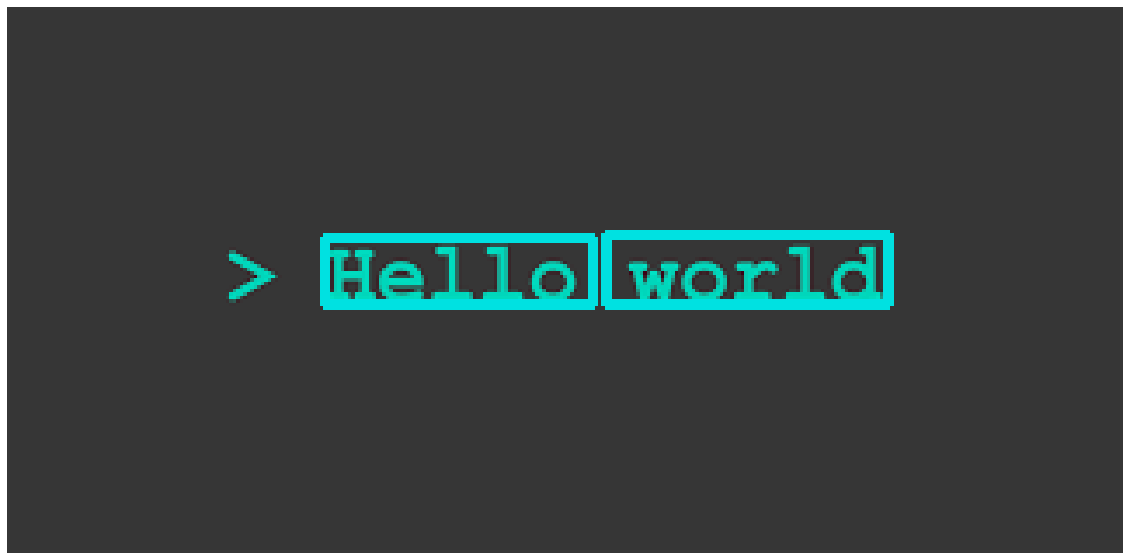

In [30]:
img_detected = img.copy()
for (x1,y1,x2,y2) in fin_boxes:
    x1=int(x1 * w_ratio)
    y1=int(y1 * h_ratio)
    x2=int(x2 * w_ratio)
    y2=int(y2 * h_ratio)
    cv2.rectangle(img_detected,(x1,y1),(x2,y2),(0,225,225),2)
fig = plt.figure(figsize=(20,20))
plt.imshow(img_detected,cmap='gray')
plt.axis('off')

<a name='6'></a>
## Important Function to Decode the scores to text

In [31]:
def most_likely(scores, char_set):
    text = ""
    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        text += char_set[c]
    return text


def map_rule(text):
    char_list = []
    for i in range(len(text)):
        if i == 0:
            if text[i] != '-':
                char_list.append(text[i])
        else:
            if text[i] != '-' and (not (text[i] == text[i - 1])):
                char_list.append(text[i])
    return ''.join(char_list)


def best_path(scores, char_set):
    text = most_likely(scores, char_set)
    final_text = map_rule(text)
    return final_text

<a name='7'></a>
## Build Recognition Model using CRNN

In [32]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_copy = img_gray.copy()
alphabet_set = "0123456789abcdefghijklmnopqrstuvwxyz"
blank = '-'
char_set = blank + alphabet_set
out_text = []
f=open('./data/structured_output.txt', mode = 'w')
for (x1,y1,x2,y2) in fin_boxes:
    
    x1=int(x1*w_ratio)
    y1=int(y1*h_ratio)
    x2=int(x2*w_ratio)
    y2=int(y2*h_ratio)
    
    # Work with detected text boxes for recognition
    blob = cv2.dnn.blobFromImage(img_gray[y1:y2, x1:x2], scalefactor=1/127.5, size=(100,32), mean=127.5)

    # Pass the image to network and extract per-timestep scores
    crnn_model.setInput(blob)

    scores = crnn_model.forward()
    #print(scores.shape)

    out = best_path(scores, char_set)
    cv2.putText(img_copy, out, (x1,y1), 0, .7, (0, 0, 255), 2 )
    l=[out,x1,y1,x2,y2]
    out_text.append(l)
    f.write(" ".join(map(str,l)))
    f.write("\n")
f.close()

<a name='8'></a>
## Preform Tesseract to Detect and Recognition Text

In [33]:
img_detected = img.copy()
for x1,y1,x2,y2 in fin_boxes:
    img_crop = Image.fromarray(img[y1-1: y2+1, x1-1:x2+1])
    text = pytesseract.image_to_string(img_crop).strip()
    cv2.putText(img_detected, text, (x1,y1), 0, .7, (0, 0, 255), 2 )

<a name='9'></a>
## Showing Results and Comparisons

(-0.5, 320.5, 156.5, -0.5)

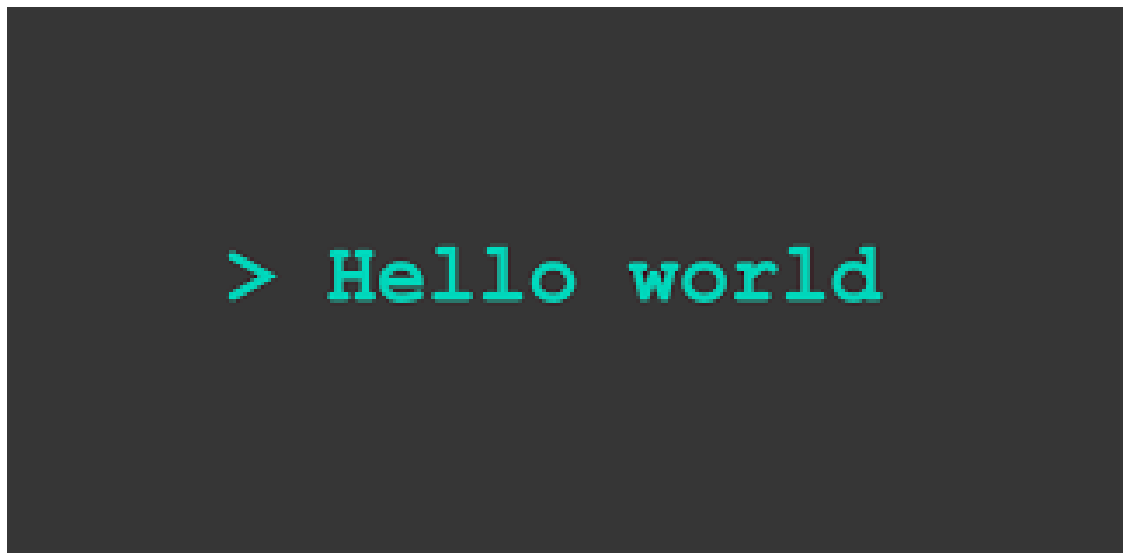

In [34]:

#tesseract results
fig = plt.figure(figsize=(20,20))
plt.imshow(img_detected)
plt.axis("off")

(-0.5, 320.5, 156.5, -0.5)

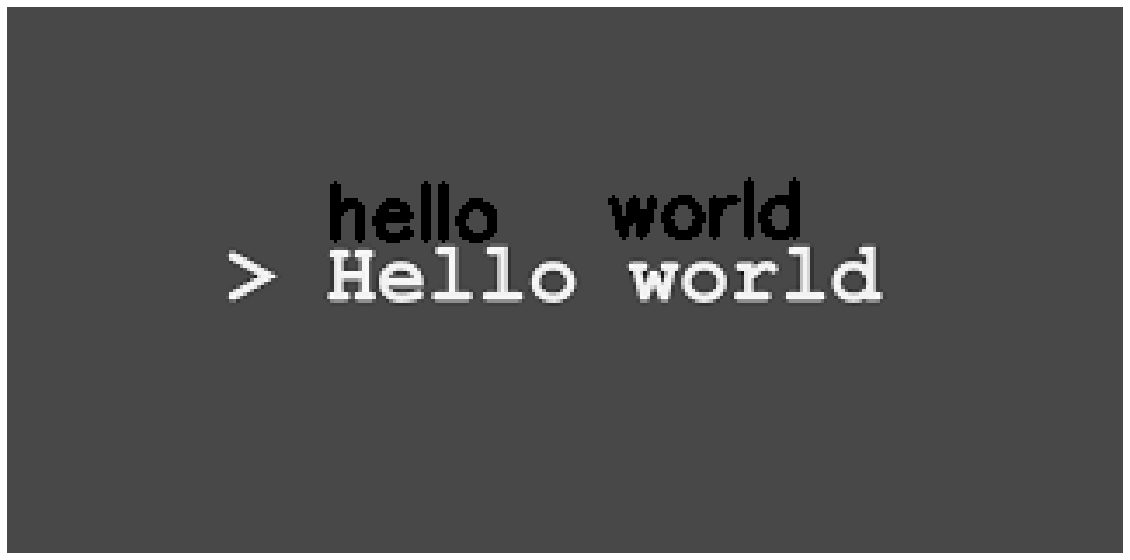

In [35]:
#CRNN Results
fig = plt.figure(figsize=(20,20))
plt.imshow(img_copy,cmap='gray')
plt.axis("off")

[['world', 172, 65, 253, 85], ['hello', 91, 66, 168, 85]]